### Testing model comparison

In [ ]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from ili.dataloaders import NumpyLoader

from sbifitter import SBI_Fitter

grid_path_1 = "/home/tharvey/work/output/grid_Pop_II_LogNormal_SFH_5_z_12_logN_5.0_BPASS_Chab_v1.hdf5"  # noqa: E501
grid_path_2 = "/home/tharvey/work/output/grid_Pop_II_LogNormal_SFH_5_z_12_logN_5.0_BPASS_Chab_SMC_v1.hdf5"  # noqa: E501

device = "cuda:0"

In [ ]:
fitter_calzetti = SBI_Fitter.init_from_hdf5(
    "BPASS_Chab_LogNorm_5_z_12_calzetti_compare_fixed2",
    grid_path_1,
    return_output=False,
    device="cuda:0",
)

fitter_smc = SBI_Fitter.init_from_hdf5(
    "BPASS_Chab_LogNorm_5_z_12_smc_compare_fixed2",
    grid_path_2,
    return_output=False,
    device="cuda:0",
)

### Generate training data

In [ ]:
fitter_calzetti.create_feature_array_from_raw_photometry(
    normalize_method=None, extra_features=[]
)
fitter_smc.create_feature_array_from_raw_photometry(
    normalize_method=None, extra_features=[]
);

### Train Models

Need a NPE and NLE model to get samples and likelihood. Training NPE and NLE for each model on the same training data.

In [ ]:
train_idx, test_idx = fitter_calzetti.split_dataset(0.8, random_seed=42)
nle1, nle1_stats = fitter_calzetti.run_single_sbi(
    engine="NLE",
    set_self=False,
    model_type="maf",
    plot=True,
    name_append="_NLE",
    hidden_features=25,
    num_transforms=2,
    train_indices=train_idx,
    test_indices=test_idx,
    learning_rate=1e-4,
    stop_after_epochs=10,
)

npe1, npe1_stats = fitter_calzetti.run_single_sbi(
    engine="NPE",
    learning_rate=5e-4,
    set_self=False,
    plot=True,
    name_append="_NPE",
    train_indices=train_idx,
    test_indices=test_idx,
)


train_idx, test_idx = fitter_smc.split_dataset(0.8, random_seed=42)
nle2, _ = fitter_smc.run_single_sbi(
    engine="NLE",
    set_self=False,
    model_type="maf",
    plot=True,
    name_append="_NLE",
    hidden_features=100,
    num_transforms=5,
    train_indices=train_idx,
    test_indices=test_idx,
)
npe2, _ = fitter_smc.run_single_sbi(
    engine="NPE",
    learning_rate=1e-3,
    set_self=False,
    plot=True,
    name_append="_NPE",
    train_indices=train_idx,
    test_indices=test_idx,
)

Plot diagnostics for the NLE method - note need to changing sampling method, as direct sampling only works for NPE 

In [ ]:
fitter_calzetti.plot_diagnostics(
    X_train=fitter_calzetti.feature_array[train_idx],
    y_train=fitter_calzetti.fitted_parameter_array[train_idx],
    X_test=fitter_calzetti.feature_array[test_idx],
    y_test=fitter_calzetti.fitted_parameter_array[test_idx],
    stats=nle1_stats,
    sample_method="vi",
    posteriors=nle1,
)

### Draw a test observation from test data - this is a Calzetti model

In [ ]:
train_idx, test_idx = fitter_calzetti.split_dataset(0.8, random_seed=42)

random_test = np.random.choice(test_idx, size=1, replace=False)

test_params = fitter_calzetti.fitted_parameter_array[random_test]

print(test_params)

x_obs = fitter_calzetti.feature_array[random_test]

print(x_obs)

### Let's also draw one from the SMC model

In [ ]:
train_idx, test_idx = fitter_smc.split_dataset(0.8, random_seed=42)
random_test2 = np.random.choice(test_idx, size=1, replace=False)
test_params2 = fitter_smc.fitted_parameter_array[random_test2]
x_obs2 = fitter_smc.feature_array[random_test2]

### Model Comparison

In [ ]:
from ili.evidence import HarmonicEvidence

estimator1 = HarmonicEvidence()
estimator1.from_nde(npe1, nle1, x=x_obs, shape=(10_000,), show_progress_bars=False)

estimator2 = HarmonicEvidence()
estimator2.from_nde(npe2, nle2, x=x_obs, shape=(10_000,), show_progress_bars=False)

In [ ]:
x = x_obs
samples = npe1.sample((10000,), x)
lnprob = nle1.potential(samples, x)

lnprob

In [ ]:
K_est, stdK_est = estimator1.get_ln_bayes_factor(estimator2)

Intepretation of Bayes Factor - (from Kass and Raftery (1995))  
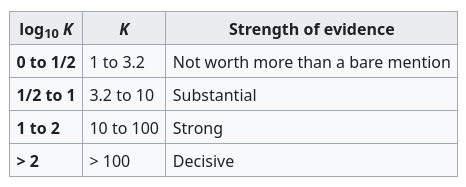

### Evidence Networks

In [ ]:
from ili.evidence import K_EvidenceNetwork

runner = K_EvidenceNetwork(
    layer_width=32,
    added_layers=6,
    batch_norm_flag=1,
    alpha=2,
    train_args=dict(
        learning_rate=1e-6,
        training_batch_size=256,
        stop_after_epochs=30,
        validation_fraction=0.1,
    ),
)

In [ ]:
train_idx, test_idx = fitter_smc.split_dataset(0.8, random_seed=42)
x_train_smc = fitter_smc.feature_array[train_idx]
y_train_smc = fitter_smc.fitted_parameter_array[train_idx]

train_idx, test_idx = fitter_calzetti.split_dataset(0.8, random_seed=42)
x_train_calzetti = fitter_calzetti.feature_array[train_idx]
y_train_calzetti = fitter_calzetti.fitted_parameter_array[train_idx]


loader_smc_train = NumpyLoader(x_train_smc, y_train_smc)
loader_calzetti_train = NumpyLoader(x_train_calzetti, y_train_calzetti)

In [ ]:
print(np.shape(y_train_calzetti), np.shape(y_train_smc))

In [ ]:
# M1 = SMC
# M2 = Calzetti
# log K = M1/M2

summary = runner.train(loader_smc_train, loader_calzetti_train)

In [ ]:
%matplotlib inline
plt.plot(summary["training_loss"], label="Train Loss")
plt.plot(summary["validation_loss"], label="Val Loss")
# plt.ylim(0.99,1.01)
plt.legend()
plt.show()

In [ ]:
X_test_cal = fitter_calzetti.feature_array[test_idx]
y_test_cal = fitter_calzetti.fitted_parameter_array[test_idx]

params = fitter_calzetti.simple_fitted_parameter_names
tau_v_idx = params.index("tau_v")
tau_v_cal = y_test_cal[:, tau_v_idx]

X_test_smc = fitter_smc.feature_array[test_idx]

y_test_smc = fitter_smc.fitted_parameter_array[test_idx]

tau_v_smc = y_test_smc[:, tau_v_idx]

K_est_cal = runner.predict(X_test_cal, y_test_cal)
K_est_smc = runner.predict(X_test_smc, y_test_smc)

log_Ks_cal = np.log(K_est_cal)
log_Ks_smc = np.log(K_est_smc)

In [ ]:
jeffries_logK = {
    (-100, -2): "deciseivly against",
    (-2, -1.5): "very strongly against",
    (-1.5, -1): "strongly against",
    (-1, -0.5): "moderately against",
    (-0.5, 0.5): "No strong evidence",
    (0.5, 1): "moderately for",
    (1, 1.5): "strongly for",
    (1.5, 2): "very strongly for",
    (2, 100): "decisively for",
}

In [ ]:
plt.scatter(tau_v_cal, log_Ks_cal, label="Calzetti", alpha=0.5, s=1)
plt.scatter(tau_v_smc, log_Ks_smc, label="SMC", alpha=0.5, s=1)

plt.xlabel("tau_v")
plt.ylabel("log K (Calzetti/SMC)")
plt.legend(title="Test Photometry")
plt.hlines(0, 0, 2, color="k", linestyle="--")
plt.hlines(1, 0, 2, color="k", linestyle="dotted")
plt.text(
    0,
    1.15,
    "Strong Evidence for Calzetti",
    rotation=0,
    fontsize=10,
    ha="left",
    va="bottom",
)
plt.hlines(-1, 0, 2, color="k", linestyle="dotted")
plt.text(
    0, -1.15, "Strong Evidence for SMC", rotation=0, fontsize=10, ha="left", va="top"
)

plt.ylim(plt.ylim())
# shade regions in between
for key, value in jeffries_logK.items():
    plt.fill_betweenx([key[0], key[1]], 0, 2, alpha=0.1, label=value)


print(
    "Fraction of True Calzetti preferred as Calzetti with log K > 0.5:",
    len(log_Ks_cal[log_Ks_cal > 0.5]) / len(log_Ks_cal),
)

print(
    "Fraction of True Calzetti prefered as SMC with log K < -0.5:",
    len(log_Ks_cal[log_Ks_cal < -0.5]) / len(log_Ks_cal),
)

print(
    "Fraction of True Calzetti preferred as SMC strongly with log K < -1:",
    len(log_Ks_cal[log_Ks_cal < -1]) / len(log_Ks_cal),
)

print(
    "Fraction of True SMC prefered as SMC with log K < -0.5:",
    len(log_Ks_smc[log_Ks_smc < -0.5]) / len(log_Ks_smc),
)

print(
    "Fraction of True SMC preferred as Calzetti with log K > 0.5:",
    len(log_Ks_smc[log_Ks_smc > 0.5]) / len(log_Ks_smc),
)

print(
    "Fraction of True SMC strongly preferred as Calzetti with log K > 0.5:",
    len(log_Ks_smc[log_Ks_smc > 1]) / len(log_Ks_smc),
)

What are the parameters of one of the Calzetti test observations which strongly favour the SMC model?

In [ ]:
mask = log_Ks_cal < -1
idx = np.random.choice(np.where(mask)[0], size=1, replace=False)

params = fitter_calzetti.fitted_parameter_array[idx]

for name, value in zip(fitter_calzetti.simple_fitted_parameter_names, params[0]):
    print(name, value)

Let's try with a Pop III model with different parameters

In [ ]:
path = "/home/tharvey/work/output/grid_yggdrasil-1.3.3-POPIII-fcov_1_salpeter-10,1,500_5_z_12_logN_4.0_v1.hdf5"  # noqa: E501

fitter_yggdrasil = SBI_Fitter.init_from_hdf5(
    "yggdrasil-1.3.3-POPIII-fcov_0.5_salpeter-10,1,500_5_z_12_logN_4.0_v1_compare",
    path,
    return_output=False,
)

In [ ]:
from unyt import Jy

# Draw depths from a normal distribution.
depth_centers = [
    30 if fitter_calzetti.raw_photometry_names[i].endswith("W") else 29.5
    for i in range(len(fitter_calzetti.raw_photometry_names))
]
depth_sigma = [
    0.2 if fitter_calzetti.raw_photometry_names[i].endswith("W") else 0.3
    for i in range(len(fitter_calzetti.raw_photometry_names))
]
# Draw 20 possible depths from a normal distribution
depths = np.random.normal(
    loc=depth_centers,
    scale=depth_sigma,
    size=(20, len(fitter_calzetti.raw_photometry_names)),
)
depths_jy = 10 ** ((depths - 8.90) / -2.5) * Jy  # 30 AB mag in all 22 filters

# Set 5 possible options - no missing bands, missing M bands, missing M bands except F410M, missing M bands except F410M and F335M, missing M bands except F410M and F070W  # noqa: E501
missing_bands = np.empty((5, len(fitter_calzetti.raw_photometry_names)))
missing_bands[0] = 0
missing_bands[1] = [
    True if band.endswith("M") else False for band in fitter_calzetti.raw_photometry_names
]
missing_bands[2] = [
    True if band.endswith("M") and band not in ["NIRCam.F410M"] else False
    for band in fitter_calzetti.raw_photometry_names
]
missing_bands[3] = [
    True if band.endswith("M") and band not in ["NIRCam.F410M", "NIRCam.F335M"] else False
    for band in fitter_calzetti.raw_photometry_names
]
missing_bands[4] = [
    True
    if (band.endswith("M") and band not in ["NIRCam.F410M"]) or band == "NIRCam.F070W"
    else False
    for band in fitter_calzetti.raw_photometry_names
]


fitter_calzetti.create_feature_array_from_raw_photometry(
    extra_features=[],
    normalize_method=None,
    scatter_fluxes=2,
    include_errors_in_feature_array=True,
    simulate_missing_fluxes=True,
    include_flags_in_feature_array=True,
    missing_flux_options=missing_bands,
    depths=depths_jy,
)

fitter_yggdrasil.create_feature_array_from_raw_photometry(
    normalize_method=None,
    extra_features=[],
    scatter_fluxes=10,
    include_errors_in_feature_array=True,
    depths=depths_jy,
    simulate_missing_fluxes=True,
    include_flags_in_feature_array=True,
    missing_flux_options=missing_bands,
);

In [ ]:
from ili.evidence import K_EvidenceNetwork

runner = K_EvidenceNetwork(
    layer_width=32,
    added_layers=6,
    batch_norm_flag=1,
    alpha=2,
    train_args=dict(
        learning_rate=1e-5,
        training_batch_size=256,
        stop_after_epochs=30,
        validation_fraction=0.1,
    ),
)

In [ ]:
train_idx_yggdrasil, test_idx_yggdrasil = fitter_yggdrasil.split_dataset(
    0.8, random_seed=42
)
x_train_yggdrasil = fitter_yggdrasil.feature_array[train_idx_yggdrasil]
y_train_yggdrasil = fitter_yggdrasil.fitted_parameter_array[train_idx_yggdrasil]

train_idx_cal, test_idx_cal = fitter_calzetti.split_dataset(0.8, random_seed=42)
x_train_calzetti = fitter_calzetti.feature_array[train_idx_cal]
y_train_calzetti = fitter_calzetti.fitted_parameter_array[train_idx_cal]


loader_yggdrasil_train = NumpyLoader(x_train_yggdrasil, y_train_yggdrasil)
loader_calzetti_train = NumpyLoader(x_train_calzetti, y_train_calzetti)

In [ ]:
summary = runner.train(loader_yggdrasil_train, loader_calzetti_train)

In [ ]:
%matplotlib inline
plt.plot(summary["training_loss"], label="Train Loss")
plt.plot(summary["validation_loss"], label="Val Loss")
# plt.ylim(0.99,1.01)
plt.legend()
plt.show()

In [ ]:
X_test_cal = fitter_calzetti.feature_array[test_idx_cal]
y_test_cal = fitter_calzetti.fitted_parameter_array[test_idx_cal]

log_Ks_cal = []
for x in X_test_cal:
    log_K = runner.predict(x).detach().numpy().squeeze()
    log_Ks_cal.append(log_K)

X_test_yggdrasil = fitter_yggdrasil.feature_array[test_idx_yggdrasil]
y_test_yggdrasil = fitter_yggdrasil.fitted_parameter_array[test_idx_yggdrasil]

log_Ks_yggdrasil = []
for x in X_test_yggdrasil:
    log_K = runner.predict(x).detach().numpy().squeeze()
    log_Ks_yggdrasil.append(log_K)


# Convert from ln to log10
log_Ks_cal = log_Ks_cal / np.log(10)
log_Ks_yggdrasil = log_Ks_yggdrasil / np.log(10)

plt.hist(log_Ks_cal, bins=10, alpha=0.5, label="Calzetti")
plt.hist(log_Ks_yggdrasil, bins=10, alpha=0.5, label="Yggdrasil")
plt.xlabel("log K (Calzetti/Yggdrasil)")
plt.legend(title="Test Photometry")
for key, value in jeffries_logK.items():
    plt.fill_betweenx([key[0], key[1]], 0, 2, alpha=0.1, label=value)

In [ ]:
runner.save_model(
    f"/home/tharvey/work/ltu-ili_testing/models/{fitter_yggdrasil.name}/evidence_network_model_v1"
)

Trying to load a model - doesn't seem to work because architecture is different. Need to save the model in a way that is architecture independent.  


In [ ]:
runner2 = K_EvidenceNetwork(
    layer_width=32,
    added_layers=6,
    batch_norm_flag=1,
    alpha=2,
    train_args=dict(
        learning_rate=1e-5,
        training_batch_size=256,
        stop_after_epochs=30,
        validation_fraction=0.1,
    ),
)

runner2.load_model(
    f"/home/tharvey/work/ltu-ili_testing/models/{fitter_yggdrasil.name}/evidence_network_model_v1.pth"
)

In [ ]:
# Setup  a fake model comparison where we are doing a test model comparison between
# two models.


def first_model(x, params):
    """Generate a first model with some noise added."""
    noise = np.random.normal(loc=0, scale=1, size=x.shape)
    model = params[0] * x + params[1] + x**2 * params[2]
    return model + noise


def second_model(x, params):
    """Generate a second model with some noise added."""
    noise = np.random.normal(loc=0, scale=1, size=x.shape)
    model = params[0] * x + params[1] + x**2 * params[2] + x**3 * params[3]
    return model + noise


# Do comparison

x = np.random.uniform(0, 100, size=(1000, 5))

params1 = np.random.uniform(0, 1, size=(1000, 5))
params2 = np.random.uniform(0, 1, size=(1000, 5))
model1 = first_model(x, params1)
model2 = second_model(x, params2)

loader_model1 = NumpyLoader(model1, params1)
loader_model2 = NumpyLoader(model2, params2)
runner = K_EvidenceNetwork(
    layer_width=32,
    added_layers=6,
    batch_norm_flag=1,
    alpha=2,
    train_args=dict(
        learning_rate=1e-6,
        training_batch_size=256,
        stop_after_epochs=30,
        validation_fraction=0.1,
    ),
)

summary = runner.train(loader_model1, loader_model2)

In [ ]:
%matplotlib inline
plt.plot(summary["training_loss"], label="Train Loss")
plt.plot(summary["validation_loss"], label="Val Loss")
# plt.ylim(0.99,1.01)
plt.legend()
plt.show()

In [ ]:
# test the model

x_test = np.random.uniform(0, 100, size=(1000, 5))
params1_test = np.random.uniform(0, 1, size=(1000, 5))
params2_test = np.random.uniform(0, 1, size=(1000, 5))
model1_test = first_model(x_test, params1_test)
model2_test = second_model(x_test, params2_test)

logK = []

for x in x_test:
    log_K = runner.predict(x).detach().numpy().squeeze()
    logK.append(log_K)
logK = np.array(logK)


plt.hist(logK, bins=100);

### Now let's try the same with the HarmonicEvidence 

Note lampe doesn't support NLE

In [ ]:
train_idx, test_idx = fitter_calzetti.split_dataset(0.8, random_seed=42)
nle1, nle1_stats = fitter_calzetti.run_single_sbi(
    engine="NLE",
    set_self=False,
    model_type="maf",
    plot=True,
    name_append="_NLE",
    hidden_features=25,
    num_transforms=2,
    train_indices=train_idx,
    test_indices=test_idx,
    learning_rate=1e-4,
    stop_after_epochs=10,
)

npe1, npe1_stats = fitter_calzetti.run_single_sbi(
    engine="NPE",
    learning_rate=5e-4,
    set_self=False,
    model_type="maf",
    plot=True,
    name_append="_NPE",
    train_indices=train_idx,
    test_indices=test_idx,
)


train_idx, test_idx = fitter_yggdrasil.split_dataset(0.8, random_seed=42)
nle2, nle2_stats = fitter_yggdrasil.run_single_sbi(
    engine="NLE",
    set_self=False,
    model_type="maf",
    plot=True,
    name_append="_NLE",
    hidden_features=25,
    num_transforms=2,
    learning_rate=1e-4,
    stop_after_epochs=10,
    train_indices=train_idx,
    test_indices=test_idx,
)
npe2, npe2_stats = fitter_yggdrasil.run_single_sbi(
    engine="NPE",
    learning_rate=1e-3,
    set_self=False,
    model_type="maf",
    plot=True,
    name_append="_NPE",
    train_indices=train_idx,
    test_indices=test_idx,
)

In [ ]:
path = "/home/tharvey/work/ltu-ili_testing/models/BPASS_Chab_LogNorm_5_z_12_calzetti_compare_fixed2"  # noqa: E501

(
    nle1,
    nle1_stats,
    _,
) = fitter_calzetti.load_model_from_pkl(path, set_self=True)

GLIMPSE Pop III candidate

In [ ]:
filters = [
    "F090W",
    "F115W",
    "F150W",
    "F200W",
    "F277W",
    "F356W",
    "F410M",
    "F444W",
    "F480M",
]
phot = np.array([3.17, 4.44, 4.74, 3.54, 3.29, 3.94, 0.71, 4.85, 12.54])
errors = np.array([0.60, 0.52, 0.61, 0.62, 0.71, 0.74, 1.21, 0.67, 2.47])
import astropy.units as u

# mask

mask = np.array(
    [
        True if f.replace("NIRCam.", "") in filters else False
        for f in fitter_calzetti.raw_photometry_names
    ]
)


err = np.log10(1 + np.abs((errors / phot)))  # Convert to log10 flux error
phot = phot * u.nJy

phot = phot.to(u.ABmag).value

print(err)
phot_fill = 99
j = 0
full_phot = []
full_err = []
full_flags = []
for i in range(len(fitter_calzetti.raw_photometry_names)):
    if mask[i]:
        full_phot.append(float(phot[j]))
        full_err.append(float(err[j]))
        full_flags.append(False)
        j += 1
    else:
        full_phot.append(phot_fill)
        full_err.append(phot_fill)
        full_flags.append(True)

full_array = np.array(full_phot + full_err + full_flags, dtype=np.float32)
full_array.shape

In [ ]:
fitter_yggdrasil.create_feature_array_from_raw_photometry(
    normalize_method=None,
    extra_features=[],
    simulate_missing_fluxes=True,
    include_flags_in_feature_array=True,
    missing_flux_options=missing_bands,
);

In [ ]:
train_idx_yggdrasil, test_idx_yggdrasil = fitter_yggdrasil.split_dataset(
    0.8, random_seed=42
)

npe2, npe2_stats = fitter_yggdrasil.run_single_sbi(
    engine="NPE",
    learning_rate=5e-4,
    set_self=True,
    model_type="nsf",
    backend="lampe",
    num_transforms=6,
    plot=True,
    name_append="_NPE3",
    train_indices=train_idx_yggdrasil,
    test_indices=test_idx_yggdrasil,
    save_model=True,
)

In [ ]:
print(fitter_calzetti.feature_names)
train_idx, test_idx = fitter_calzetti.split_dataset(0.8, random_seed=42)

npe1, npe1_stats = fitter_calzetti.run_single_sbi(
    engine="NPE",
    learning_rate=5e-4,
    set_self=False,
    model_type="nsf",
    backend="lampe",
    plot=True,
    name_append="_NPE",
)

In [ ]:
fitter_calzetti.fitted_parameter_array[:100]

In [ ]:
fitter_calzetti.__dict__